In [1]:
import cv2
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import pywt
import pandas as pd

from keras import applications
from skimage.color import rgb2gray

import numpy as np

from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import utils
from keras import optimizers

import os
import sys

#image_folder = '/Volumes/Data/Docs/Kuliah/IITD Palmprint V1/Segmented/Right/'
#image_folder = '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/Segmented/Left/'
#image_folder = '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/'
image_folder = '/Volumes/Data/Docs/Kuliah/Palm Print/CASIA PolyU/PolyU-Pure/'


# sample image
img = cv2.imread( '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/001_1.JPG')
img2 = cv2.imread( '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/001_2.JPG')
img3 = cv2.imread( '/Volumes/Data/Docs/Kuliah/Palm Print/IITD V1/ROI Left Hand/001_3.JPG')

# models name
efficientnet_model = "PolyU_EN.keras"
resnet_model = "PolyU_RN.keras"

batch_size = 32
no_of_epochs = 100

image_size = 128 # input roi image size

sys.setrecursionlimit(150000)

In [2]:
def w2d(img, mode='haar', level=1):
    image_data = img
    
    #Datatype conversions
    image_data = cv2.cvtColor( image_data,cv2.COLOR_RGB2GRAY )
    #convert to float
    image_data =  np.float32(image_data)
    image_data /= 255;
    # compute coefficients 
    coef=pywt.wavedec2(image_data, mode, level=level)

    #Process Coefficients
    coef_H=list(coef)
    coef_H[0] *= 0;

    # reconstruction
    image_data_H=pywt.waverec2(coef_H, mode);
    image_data_H *= 255;
    image_data_H =  np.uint8(image_data_H)

    return image_data_H

In [3]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [4]:
#filter name

In [5]:

def apply_canny_edge(image, low_threshold=50, high_threshold=150, blur_ksize=5):
    """
    Applies the Canny Edge Detection algorithm to the input image.

    Parameters:
        image (numpy.ndarray): Input image (grayscale or color).
        low_threshold (int): Lower bound for edge detection thresholds.
        high_threshold (int): Upper bound for edge detection thresholds.
        blur_ksize (int): Kernel size for Gaussian blur (must be an odd number).

    Returns:
        edges (numpy.ndarray): Binary image with edges highlighted.
    """
    # Convert to grayscale if the input image is in color
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apply Gaussian Blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (blur_ksize, blur_ksize), 0)

    # Apply Canny Edge Detection
    edges = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edges

In [6]:
def get_palm_lines(image):
    rgb_planes = cv2.split(image)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        #clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        #norm_img = clahe.apply(norm_img)


        # Scale to range 0 to 255 for visualization purposes
        #        norm_img = (norm_img * 255).astype(np.uint8)

        #        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        #        norm_img = clahe.apply(norm_img)
        _, norm_img = cv2.threshold(norm_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        #       avg_intensity = np.mean(norm_img)

        # Set the new thresholds based on 25% of the average intensity
        #       dark_threshold = avg_intensity * 1.25  # Dark threshold is 125% of average intensity
        #       light_threshold = avg_intensity * 0.25  # Light threshold is 25% of average intensity

        # Apply the threshold conditions
        # multiply it?
        #        normalized_img = np.where(norm_img > dark_threshold, 0, norm_img)       # Darken pixels above dark threshold
        #        normalized_img = np.where(normalized_img < light_threshold, 255, normalized_img)  # Lighten pixels below light threshold

        #        norm_img = np.where(norm_img < 255, norm_img // 5, norm_img)
        #       norm_img[norm_img > 46] = 255

        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm



In [7]:
def reduce_shadow(image):
    rgb_planes = cv2.split(image)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        norm_img = clahe.apply(diff_img)


        # Scale to range 0 to 255 for visualization purposes
        #        norm_img = (norm_img * 255).astype(np.uint8)

        #        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        #        norm_img = clahe.apply(norm_img)

        #       avg_intensity = np.mean(norm_img)

        # Set the new thresholds based on 25% of the average intensity
        #       dark_threshold = avg_intensity * 1.25  # Dark threshold is 125% of average intensity
        #       light_threshold = avg_intensity * 0.25  # Light threshold is 25% of average intensity

        # Apply the threshold conditions
        # multiply it?
        #        normalized_img = np.where(norm_img > dark_threshold, 0, norm_img)       # Darken pixels above dark threshold
        #        normalized_img = np.where(normalized_img < light_threshold, 255, normalized_img)  # Lighten pixels below light threshold

        #        norm_img = np.where(norm_img < 255, norm_img // 5, norm_img)
        #       norm_img[norm_img > 46] = 255

        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm

In [8]:

def color_to_bw_and_normalize(image):
    """
    Converts a color image to grayscale and normalizes the intensity.

    Parameters:
        image (numpy.ndarray): Input color image (BGR format).

    Returns:
        normalized_bw (numpy.ndarray): Normalized grayscale image.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize intensity to range 0–255
    normalized_bw = cv2.normalize(
        gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
    )

    return normalized_bw



In [9]:
def center_crop(image, crop_size=150):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the center point
    center_x, center_y = width // 2, height // 2

    # Define the cropping box
    x_start = max(center_x - crop_size // 2, 0)
    y_start = max(center_y - crop_size // 2, 0)
    x_end = x_start + crop_size
    y_end = y_start + crop_size

    # Ensure the crop size does not exceed the image dimensions
    x_end = min(x_end, width)
    y_end = min(y_end, height)

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    # Convert to grayscale if the image is in color
#    if len(cropped_image.shape) == 3:
 #       cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        
    return cropped_image

In [10]:
img.shape

(224, 224, 3)

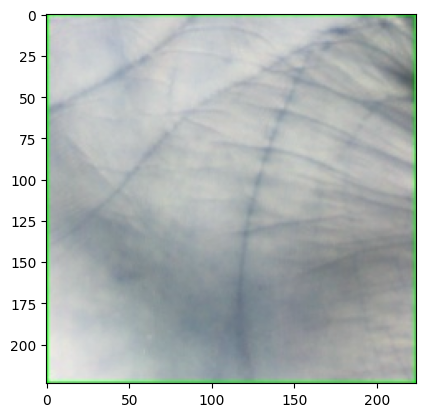

In [11]:
plt.imshow(img)

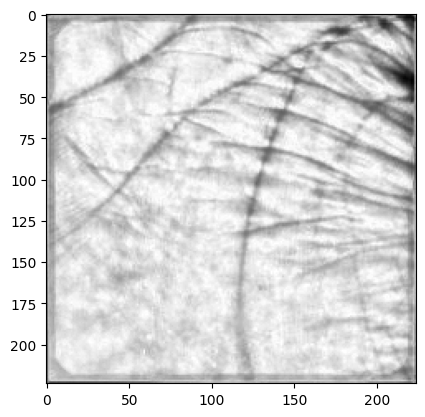

In [12]:
img_n = reduce_shadow(img)
img_bw = color_to_bw_and_normalize(img_n)
plt.imshow(img_bw, cmap='gray')

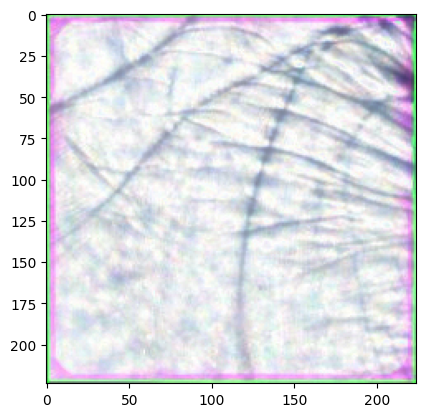

In [13]:
img_n = reduce_shadow(img)
plt.imshow(img_n)


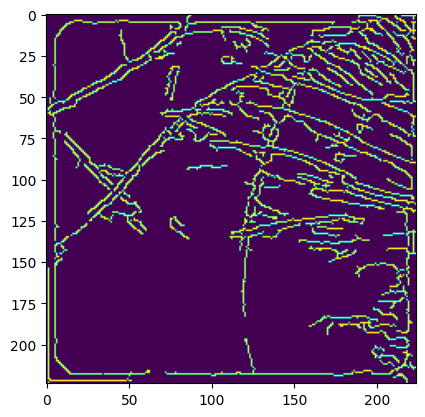

In [14]:
#img_canny = apply_canny_edge(img, 0 , 35)
img_canny = apply_canny_edge(img_n, 50 , 100)
plt.imshow(img_canny)

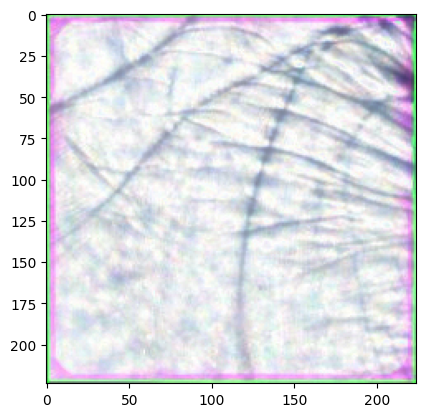

In [15]:
# Assuming result_norm is your processed image
result_norm = reduce_shadow(img)
#centered_crop = center_crop(result_norm, 150)

plt.imshow(result_norm)

In [16]:
def hough_transform_visualization(img, rho_resolution=1, theta_resolution=np.pi/180, threshold=100):
    """
    Perform Hough Transform on an image and visualize the results.

    Parameters:
    - img: Input image (RGB or grayscale)
    - rho_resolution: Distance resolution in pixels of the Hough grid
    - theta_resolution: Angle resolution in radians of the Hough grid
    - threshold: Accumulator threshold parameter for line detection
    
    Returns:
    - lines: Detected lines in the form of rho and theta pairs
    """
    # Convert image to grayscale if it is in RGB
    gray_img = rgb2gray(img) if img.ndim == 3 else img

    # Step 1: Apply edge detection (e.g., Canny) for the Hough transform input
    edges = cv2.Canny((gray_img * 255).astype(np.uint8), 50, 100)

    # Step 2: Perform Hough Transform using OpenCV
    lines = cv2.HoughLines(edges, rho_resolution, theta_resolution, threshold)

    # Create a blank image to accumulate lines
    accumulator = np.zeros_like(edges)
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * a)
            cv2.line(accumulator, (x1, y1), (x2, y2), 255, 1)

    # Flatten the accumulator to create a feature vector
    feature_vector = accumulator.flatten()

    return feature_vector, lines
    

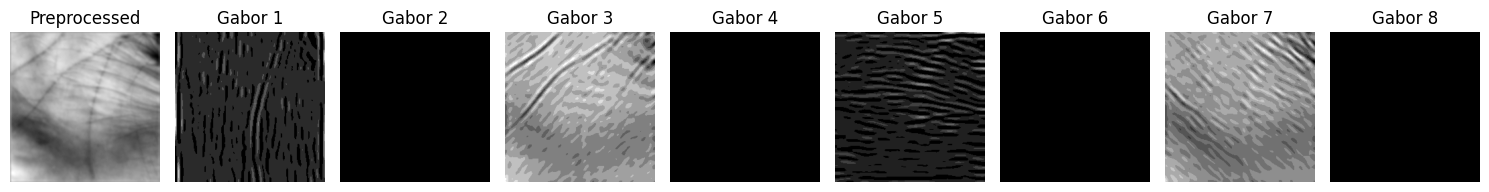

In [17]:
def load_image(image_path):
    """Load an image from the given path."""
    return cv2.imread(image_path)

def blur_to_gray_image(img):
    """Convert to grayscale and apply Gaussian blur."""
    gray_img = rgb2gray(img) if img.ndim == 3 else img
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    return blurred_img

def apply_gabor_filters(img, num_filters=8):
    """Apply Gabor filters to the image."""
    filters = []
    for theta in np.arange(0, np.pi, np.pi / num_filters):
        kernel = cv2.getGaborKernel((21, 21), 8.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        filters.append(filtered_img)
    return filters

def visualize_images(images, titles):
    """Visualize a list of images with titles."""
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Preprocess the image
preprocessed_img = blur_to_gray_image(img3)

# Apply Gabor filters
gabor_images = apply_gabor_filters(preprocessed_img)

# Visualize results
visualize_images([preprocessed_img] + gabor_images, ['Preprocessed'] + [f'Gabor {i+1}' for i in range(len(gabor_images))])

In [18]:

vgg16_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in vgg16_base.layers:
    layer.trainable = False

# Function to extract features from palm images
def extract_features(dataset):
    features = vgg16_base.predict(dataset)
    return features


def normalize_palm_image(img):

    # Step 1: Histogram Equalization for contrast enhancement
    img = cv2.equalizeHist(img)

    # Step 2: Apply Gaussian Blur to smooth out noise while retaining edges
    img = cv2.GaussianBlur(img, (5, 5), 0)
#    plt.imshow(img)

    # Step 4: Apply adaptive thresholding to highlight the palm texture
    adaptive_thresh = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, blockSize=15, C=5)

    return adaptive_thresh


In [19]:
#normalized_palm_texture = normalize_palm_image(centered_crop)
normalized_palm_texture2 = hough_transform_visualization(img2)
normalized_palm_texture3 = hough_transform_visualization(img3)

#plt.imshow(normalized_palm_texture2)

In [20]:
#wavelet_img = increase_brightness(img,50)
#wavelet_img = cv2.addWeighted( img, 1, img, 0, 20)
alpha = 1 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

wavelet_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

b = img.copy()
# set green and red channels to 0
b[:, :, 1] = 0
b[:, :, 2] = 0


g = img.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

r = img.copy()
# set blue and green channels to 0
r[:, :, 0] = 0
r[:, :, 1] = 0



In [21]:
from torchvision import transforms
from PIL import Image
from keras import preprocessing

# Define the transformation pipeline
transform = transforms.Compose([
    # Resize to 150x150, required input size for VGG16
    transforms.Resize((image_size, image_size)),

    # Convert image to tensor
    transforms.ToTensor(),

    # Repeat grayscale channel to create 3 channels (if your images are grayscale)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.150, 0.225])
])

# Sample usage with an image file
def preprocess_image(image_path):
    # Open the image file

    img = preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
    img_array = preprocessing.image.img_to_array(img)  # shape: (150, 150, 3)
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 150, 150, 3)

    # Apply transformations
#    img_transformed = transform(img_array)
    return img_array


Loaded 6000 images with corresponding labels.
Image shape: (6000, 128, 128, 3)
Labels shape: (6000,)


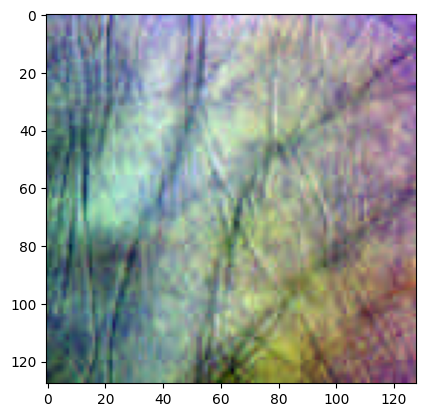

In [22]:
# Path to the folder containing palmprint cropped images
# Blurred image is skipped due full hand undetected by mediapipe
# increasing the quality of data

# images and labels will be loaded into these lists:
# `images` is a list of all images
# `labels` is a list of corresponding labels (person id)
croppeds = []
images = []
labels = []

def get_category_id(filename):
    """
    Extracts the category ID from the filename formatted as B_0001_01.
    """
    # Extract the color (B, G, or R) and numeric category ID from the filename
    category_id = int(filename[2:6])  # Digits from position 3 to 7

    return category_id


allowed_extensions = (".jpg", ".jpeg", ".bmp", ".tiff")

# Loop through the folder and read each file
for filename in os.listdir(image_folder):
    if filename.lower().endswith(allowed_extensions) and filename.startswith('B'):
        # Extract the 3 - 7  characters of the filename
        data_id = get_category_id(filename) # tongji

        # Create filenames for G and R versions
        filename_g = filename.replace("B", "G", 1)  # Replace the first 'B' with 'G'
        filename_r = filename.replace("B", "R", 1)  # Replace the first 'B' with 'R'
        
        # Full path to the image file
        img_path_b = os.path.join(image_folder, filename)
        img_path_g = os.path.join(image_folder, filename_g)
        img_path_r = os.path.join(image_folder, filename_r)

        # Read the image using OpenCV
        image_b = cv2.imread(img_path_b, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        image_g = cv2.imread(img_path_g, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        image_r = cv2.imread(img_path_r, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

        # Check if all images are properly loaded
        if image_b is None or image_g is None or image_r is None:
            print("One or more images failed to load. Check paths.")
        else:
            # Combine the three grayscale images into a color image
            image = cv2.merge((image_b, image_g, image_r))  # Merge in BGR, OpenCV default

        images.append(image)
        labels.append(data_id)

# Convert lists to numpy arrays for compatibility with machine learning models
croppeds = np.array(croppeds)
images = np.array(images)
labels = np.array(labels)

# Print shapes to verify loading
print(f"Loaded {len(images)} images with corresponding labels.")
print(f"Image shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# print last image to see colour
plt.imshow(image)

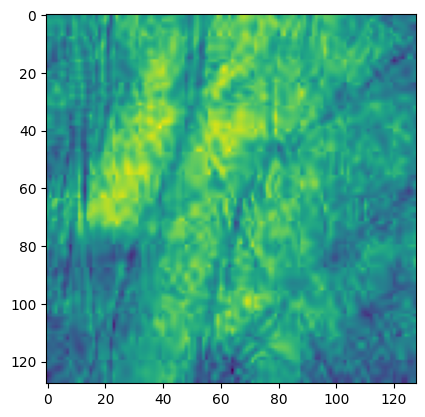

In [23]:

plt.imshow(image_g)

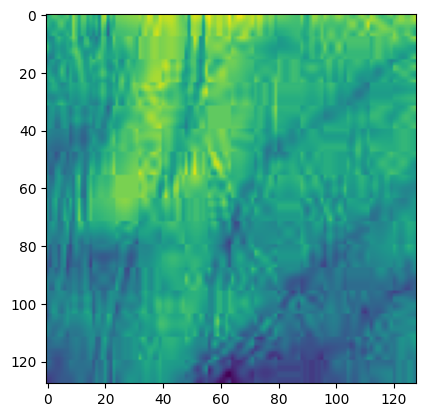

In [24]:

plt.imshow(image_r)

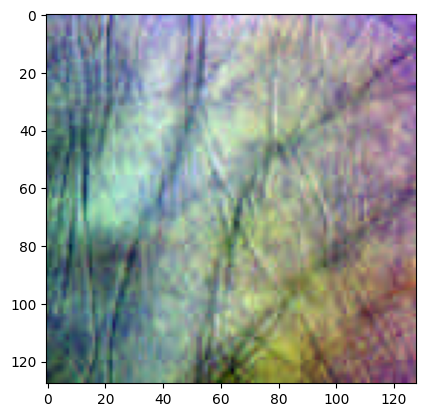

In [25]:
plt.imshow(image)

Training set size: 4800
Y Train: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 2

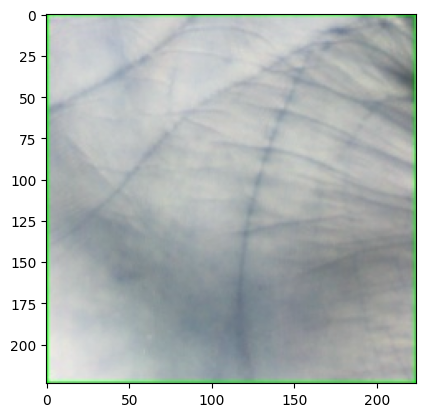

In [26]:
plt.imshow(img)
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.20, random_state=66)

#X_trainx, X_testx, y_trainx, y_testx = train_test_split(croppeds, labels, test_size=0.20, random_state=66)

# Verifying the split
print(f'Training set size: {X_train.shape[0]}')
print(f'Y Train: {np.unique(labels)}')
print(f'Test set size: {X_test.shape[0]}')



In [27]:

# Preprocessing: Reshape images and one-hot encode labels
X_train = X_train.reshape(X_train.shape[0], image_size, image_size, 3)  # (num_samples, height, width, channels)
X_test = X_test.reshape(X_test.shape[0], image_size, image_size, 3)

# Normalize pixel values to range [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Map group IDs (user IDs) to integer labels
unique_train_ids = sorted(set(y_train))
group_to_label_train = {group_id: i for i, group_id in enumerate(unique_train_ids)}
integer_labels_train = [group_to_label_train[group_id] for group_id in y_train]

# Same for test group IDs
all_unique_ids = sorted(set(y_train) | set(y_test))
group_to_label = {group_id: i for i, group_id in enumerate(all_unique_ids)}

# Map both training and testing labels
integer_labels_train = [group_to_label[group_id] for group_id in y_train]
integer_labels_test = [group_to_label[group_id] for group_id in y_test]

# Get the total number of classes
num_classes = len(all_unique_ids)

# Convert to one-hot encoding
y_train_encoded = utils.to_categorical(integer_labels_train, num_classes=num_classes)
y_test_encoded = utils.to_categorical(integer_labels_test, num_classes=num_classes)

In [28]:
# Train
# Preprocessing: Reshape images and one-hot encode labels
#X_trainx = X_trainx.reshape(X_trainx.shape[0], image_size, image_size, 1)  # (num_samples, height, width, channels)
#X_testx = X_testx.reshape(X_testx.shape[0], image_size, image_size, 1)

# Normalize pixel values to range [0,1]
#X_trainx = X_trainx.astype('float32') / 255.0
#X_testx = X_testx.astype('float32') / 255.0

#y_train_adjustedx = y_trainx - y_trainx.min()
#y_test_adjustedx = y_testx - y_testx.min()

# Convert labels to categorical (one-hot encoded)
#y_train_encodedx = utils.to_categorical(y_train_adjustedx, num_classes=num_classes)
#y_test_encodedx = utils.to_categorical(y_test_adjustedx, num_classes=num_classes)

# Define the CNN model
model = models.Sequential()

# Add Convolutional layers, Pooling layers, and Dropout for regularization
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature map into a vector
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization

# Output layer (Softmax for multi-class classification)
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model (using categorical crossentropy for multi-class classification)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model 1
# history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_test, y_test_encoded))

# Print model summary
model.summary()

In [29]:
#layers.Conv2D alexNet 100 epox

model = models.Sequential([
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3)),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:

# Step 1: Debug the shape of your data
print(f"Shape of X_train before reshaping: {X_train.shape}")
print(f"Expected number of elements after reshaping: {X_train.shape[0]} * ", image_size, " * " ,image_size , " * 3")


# Check if the total number of elements match
num_elements = np.prod(X_train.shape)  # Total number of elements in X_train
expected_elements = X_train.shape[0] * image_size * image_size * 3  # Expected elements after resizing
print(f"Actual elements: {num_elements}, Expected elements: {expected_elements}")

Shape of X_train before reshaping: (4800, 128, 128, 3)
Expected number of elements after reshaping: 4800 *  128  *  128  * 3
Actual elements: 235929600, Expected elements: 235929600


In [31]:
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")

y_train_encoded shape: (4800, 500)
y_test_encoded shape: (1200, 500)


In [32]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=no_of_epochs, batch_size= batch_size, validation_data=(X_test, y_test_encoded))

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 429ms/step - accuracy: 0.0048 - loss: 6.6320 - val_accuracy: 0.0025 - val_loss: 6.3064
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 417ms/step - accuracy: 0.0472 - loss: 5.3823 - val_accuracy: 0.1250 - val_loss: 4.4095
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 411ms/step - accuracy: 0.1680 - loss: 4.0991 - val_accuracy: 0.3458 - val_loss: 2.9918
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 480ms/step - accuracy: 0.3534 - loss: 2.7887 - val_accuracy: 0.5050 - val_loss: 2.1389
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 412ms/step - accuracy: 0.5499 - loss: 1.8152 - val_accuracy: 0.6342 - val_loss: 1.4335
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 69s 458ms/step - accuracy: 0.6705 - loss: 1.2222 - val_accuracy: 0.7983 - val_loss: 0.8170
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 441ms/step - accuracy: 0.7574 - loss: 0.8680 - val_accuracy: 0.8642 - val_loss: 0.4924
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 414ms/step - accuracy: 0.8238 -

In [33]:
base_model_en = applications.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers on top of ResNet50
x = base_model_en.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)  # For multi-class classification


if os.path.exists(efficientnet_model):
    model_en = models.load_model(efficientnet_model)
else:
    # Create a model instance
    model_en = models.Model(inputs=base_model_en.input, outputs=predictions)
    
    # Step 3: Compile the model
    model_en.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Step 4: Train the model
    history_en = model_en.fit(X_train, y_train_encoded,
                        validation_data=(X_test, y_test_encoded),
                        epochs=no_of_epochs,
                        batch_size=batch_size)

    model_en.save(efficientnet_model)

# Step 5: Evaluate the model
test_loss, test_accuracy = model_en.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.0172 - loss: 6.1531 - val_accuracy: 0.1475 - val_loss: 5.6658
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.3007 - loss: 5.0905 - val_accuracy: 0.5033 - val_loss: 3.7639
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.6984 - loss: 2.7475 - val_accuracy: 0.8533 - val_loss: 1.5387
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9409 - loss: 0.8935 - val_accuracy: 0.9883 - val_loss: 0.3582
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9949 - loss: 0.2015 - val_accuracy: 0.9992 - val_loss: 0.1177
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9997 - loss: 0.0722 - val_accuracy: 1.0000 - val_loss: 0.0578
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9977 - loss: 0.0470 - val_accuracy: 1.0000 - val_loss: 0.0400
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9995 - loss: 0.0291 - 

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=PolyU_EN.

In [36]:

model_en.save('PolyU_EN.keras')


In [37]:
model.save("PolyU_CNN.keras")


In [34]:
# Get predicted probabilities and convert them to predicted class labels
y_probabilities = model_en.predict(X_test)
y_predicted = np.argmax(y_probabilities, axis=1)  # Convert probabilities to class indices

# Print the predicted probabilities
print("Predicted Probabilities:")
print(y_probabilities)

# print probabilities for each sample
#for i, prob in enumerate(y_probabilities):
 #   print(f"Sample {i + 1}: {prob}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step
Predicted Probabilities:
[[8.7833200e-15 5.0874196e-12 2.2105456e-10 ... 1.4062498e-11
  1.1024098e-12 1.3802906e-10]
 [4.4373802e-09 8.5803691e-12 1.3904973e-10 ... 6.8610992e-11
  4.5914844e-10 1.1084730e-12]
 [2.2145404e-13 5.0327916e-14 6.1046999e-15 ... 4.0542331e-14
  2.0568340e-16 8.4195304e-15]
 ...
 [3.9945033e-13 1.2795360e-16 3.6507160e-12 ... 3.5695292e-16
  1.2314501e-12 1.0462325e-13]
 [1.1663449e-12 2.7122961e-14 2.0510245e-12 ... 1.4805159e-16
  3.8663948e-13 5.5140850e-15]
 [1.1752627e-10 6.9583913e-12 8.8212002e-15 ... 9.1924454e-14
  6.8563373e-13 2.7010925e-14]]


In [32]:
y_actual = np.argmax(y_test_encoded, axis=1)  # Convert one-hot encoded labels to class indices

# Create a DataFrame to compare actual and predicted values
comparison_table = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_predicted
})

# Display the table
print("Comparison of Actual and Predicted:")
print(comparison_table)

Comparison of Actual and Predicted:
      Actual  Predicted
0        356        356
1         34         34
2        309        309
3        331        331
4        575        575
...      ...        ...
1195     277        277
1196     531        531
1197     558        558
1198     432        432
1199     128        128

[1200 rows x 2 columns]


In [28]:
base_model_rn = applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers on top of ResNet50V2
x = base_model_rn.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)  # For multi-class classification

if os.path.exists(resnet_model):
    model_rn = models.load_model(resnet_model)
else:
    # Create a model instance
    model_rn = models.Model(inputs=base_model_rn.input, outputs=predictions)
    
    # Step 3: Compile the model
    model_rn.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    
    # Step 4: Train the model
    history_rn = model_rn.fit(X_train, y_train_encoded,
                              validation_data=(X_test, y_test_encoded),
                              epochs=no_of_epochs,
                              batch_size=batch_size)
    model_rn.save(resnet_model)

# Step 5: Evaluate the model
test_loss, test_accuracy = model_rn.evaluate(X_test, y_test_encoded)
print(f"ResNet50 Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.0554 - loss: 6.1536 - val_accuracy: 0.0250 - val_loss: 6.3299
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.7629 - loss: 2.1462 - val_accuracy: 0.2567 - val_loss: 4.0889
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9919 - loss: 0.1369 - val_accuracy: 0.7650 - val_loss: 1.3560
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 1.0000 - loss: 0.0213 - val_accuracy: 0.9142 - val_loss: 0.5619
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.9917 - val_loss: 0.0849
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9942 - val_loss: 0.0447
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9933 - val_loss: 0.0366
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 1.0000 - loss: 0.0028 - 

2024-11-21 17:09:44.480927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [1,1,2048,512]
	 [[{{function_node __inference_one_step_on_data_35842}}{{node adam/truediv_325}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/truediv_325 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/mx/bmdkcqmd3xx4q63bbd711hv80000gn/T/ipykernel_44550/1918319960.py", line 18, in <module>

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 344, in apply_gradients

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 409, in apply

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 472, in _backend_apply_gradients

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 122, in _backend_update_step

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 136, in _distributed_tf_update_step

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 133, in apply_grad_to_update_var

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/optimizers/adam.py", line 147, in update_step

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 5876, in divide

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/sparse.py", line 780, in sparse_wrapper

  File "/Users/Mac/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 2316, in divide

Incompatible shapes: [0] vs. [1,1,2048,512]
	 [[{{node adam/truediv_325}}]] [Op:__inference_one_step_on_iterator_37111]

In [34]:
# Get predicted probabilities and convert them to predicted class labels
y_probabilities = model_rn.predict(X_test)
y_predicted = np.argmax(y_probabilities, axis=1)  # Convert probabilities to class indices

# Print the predicted probabilities
#print("Predicted Probabilities:")
#print(y_probabilities)

# print probabilities for each sample
for i, prob in enumerate(y_probabilities):
    print(f"Sample {i + 1}: {prob}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sample 354: [5.49788470e-04 1.31525903e-05 1.72932632e-04 2.89526477e-04
 7.52160605e-03 6.01105741e-04 1.01333811e-04 3.11975763e-03
 3.65294654e-05 8.66712653e-05 1.80480033e-02 8.76184422e-05
 1.00863597e-03 2.29884885e-04 6.00308820e-04 1.72483808e-04
 2.68171745e-04 1.47611681e-05 1.03794962e-04 4.87069519e-05
 1.08570988e-04 2.84131587e-04 1.55479759e-01 2.69981363e-04
 1.15614366e-02 1.27145881e-03 5.90308511e-04 5.10732280e-05
 3.80062498e-04 3.97422205e-04 1.31708919e-03 2.30091944e-04
 4.79981041e-04 3.68881418e-04 3.77905997e-03 8.29805969e-04
 2.46380013e-03 1.93178043e-04 4.88103251e-05 4.78836882e-05
 3.90087487e-04 2.15907967e-05 1.72578410e-04 4.74365009e-03
 1.51012282e-04 3.44025390e-03 5.73068915e-04 2.57752818e-05
 5.71946963e-04 1.09614062e-04 1.19881169e-03 2.03319632e-05
 6.03540357e-05 7.26918370e-06 1.10753812e-03 2.86522874e-04
 1.95557805e-05 3.51123104e-04 5.69783966e-04 1.14783339e-04
 2.54378701e-03 2.05376698e-03 4.21213772e-05 1.19948061e-03
 6.46240041e

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [35]:
y_actual = np.argmax(y_test_encoded, axis=1)  # Convert one-hot encoded labels to class indices

# Create a DataFrame to compare actual and predicted values
comparison_table = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_predicted
})

# Display the table
print("Comparison of Actual and Predicted:")
print(comparison_table)

Comparison of Actual and Predicted:
      Actual  Predicted
0        356         22
1         34        448
2        309        179
3        331        215
4        575         25
...      ...        ...
1195     277         70
1196     531        218
1197     558        226
1198     432        218
1199     128        122

[1200 rows x 2 columns]
